# AI - CA5 - Neural Network - Phase 1 - Mohamad Taha Fakharian
## Goal
In this assignment, we're going to train a neural network on a handwritten persian digits dataset. Let's start!

## Overall approach
In order to train the network, we first need to read the datasets, then apply some preprocessing and after that, train the model and see the impact of hyperparameters on the accuracy of the model. Let's import some useful libraries:

In [93]:
import cv2
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import random

Since we use Google Colab to train the model, we need to upload the dataset on the drive:

In [71]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Let's import the dataset using pickle:

In [72]:
data = open('drive/My Drive/Uni/Term6/AI/dataset/data.pkl', 'rb')
data = pickle.load(data)

labels = open('drive/My Drive/Uni/Term6/AI/dataset/labels.pkl', 'rb')
labels = pickle.load(labels)

Now we split the dataset to train and test datasets(20 percentage of dataset goes to test and other goes to train):

In [73]:
data_train, data_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

## Phase 1: Data preprocessing and visualization
Before doing anything, let's see a random image from train dataset:

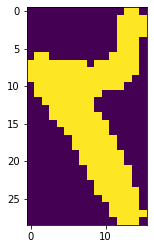

In [74]:
plt.imshow(random.choice(data_train))
plt.show()

Let's see the range of the values each pixel can get:

In [75]:
data_train[0].min(), data_train[0].max()

(0, 255)

Since not all images in dataset have same shape, we'll resize each image to 25 * 25, using cv2 library:

In [76]:
X_train = [cv2.resize(img, dsize=(25, 25)) for img in data_train]
X_test = [cv2.resize(img, dsize=(25, 25)) for img in data_test]

Now we'll show an image for each number with the number itself in the train dataset:

Number = 0


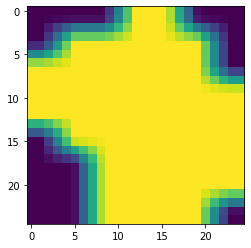


Number = 1


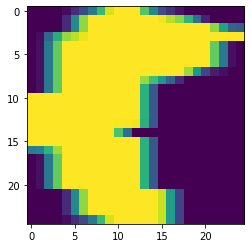


Number = 2


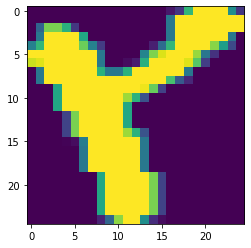


Number = 3


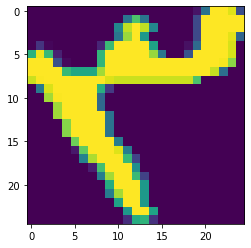


Number = 4


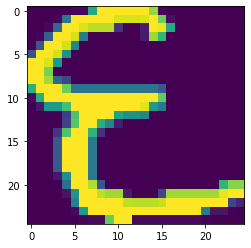


Number = 5


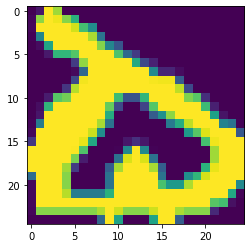


Number = 6


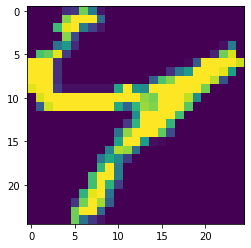


Number = 7


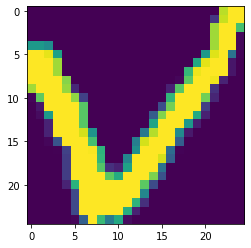


Number = 8


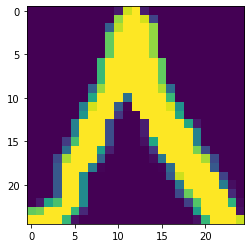


Number = 9


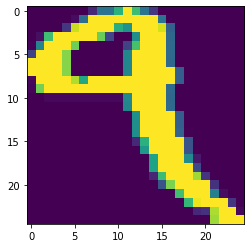

In [77]:
for i in range(0, 10):
  print("Number = {}".format(i))
  index = y_train.index(i)
  plt.imshow(X_train[index])
  plt.show()
  print()

Now let's see the distribution of classes among train and test dataset, using 'Counter' and plot a bar chart for that:

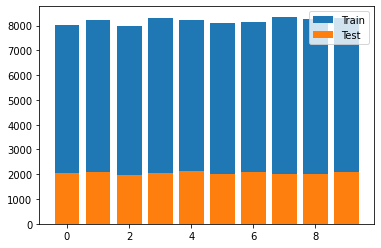

In [78]:
from collections import Counter

plt.bar(*zip(*Counter(y_train).items()), label='Train')
plt.bar(*zip(*Counter(y_test).items()), label='Test')
plt.legend()
plt.show()

As you can see, we have nearly equal number of rows for each class, both for train and test datasets.

Finally, we'll scale the datasets. Scaling is used to set the pixels values in the range of 0 to 1. Neural networks process inputs using small weight values, and inputs with large integer values e.g. 255 can disrupt or slow down the learning process.
Note that if we use imread, the pixels values stored in the arrays are already scaled between 0 and 1. This is because the imread method automatically scales the image. We'll flatten the 2d array to 1d array, in order to feed it to the network as input:

In [79]:
X_train = [img.flatten() / 255 for img in X_train]
X_test = [img.flatten() / 255 for img in X_test]

## Phase 2: Completing the code
Now, we'll complete the code for each component of the network like Dataloader, activation functions, loss function, layer and the entire network. Let's go!

### Dataloader

In [80]:
class Dataloader:
    '''
    This class prepares the dataset for the neural network.
    '''
    
    def __init__(self, data, labels, n_classes, batch_size=None, shuffle=False):
        '''
        This is the constructor. It gets dataset information and initializes the 
        Dataloader class fields.
            Parameters:
                data: features your dataset in pandas.Dataframe format.
                labels: labels of your dataset in pandas.Dataframe format.
                n_classes: number of classes you have in your dataset.
                batch_size: the number of samples that will be propagated through the network.
                shuffle: boolean value indicating whether or not the dataset should be shuffled
        '''

        assert len(data)==len(labels)

        self.__n_classes = n_classes
        self.__batch_size = batch_size
        self.__shuffle = shuffle
        self.__data = data
        self.__onehot_labels = self.__onehot(labels, self.__n_classes)
    
    def __onehot(self, labels, n_classes):
        '''
        This private method gets labels and provides one_hot vectors of labels.
        For categorical variables where no such ordinal relationship exists,
        the integer encoding is not enough.
        In this case, a one-hot encoding can be applied to the integer representation.
        This is where the integer encoded variable is removed, and a new binary variable is
        added for each unique integer value.
        example:
            red,    green,    blue
            1,      0,        0
            0,      1,        0
            0,      0,        1
                Parameters:
                        label: lables of your dataset in pandas.Dataframe format.
                        n_classes: number of classes you have in your dataset.
                
                Returns:
                    onehot_vectors: onehot vectors of the labels
        '''
        onehot_vectors = pd.DataFrame(OneHotEncoder().fit_transform(labels).toarray())
        return onehot_vectors
    
    def __shuffle_dataset(self):
        '''
        This private method shuffles your dataset.
        It uses data and onehot_labels to shuffle them
        symmetrical.
        '''
        perm = np.random.permutation((self.__data.shape[0]))
        self.__data = self.__data[perm]
        self.__onehot_labels = self.__onehot_labels[perm]

    def __iter__(self):
        '''
        The __iter__() function returns an iterator for the
        given object (array, set, tuple, etc., or custom objects).
        This will return your dataset in the batch_size given. This should
        be used to provide data for the neural network.
        '''
        
        if self.__shuffle:
            self.__shuffle_dataset()
            
        if self.__batch_size==None:
            yield (np.matrix(self.__data), np.matrix(self.__onehot_labels))
            return

        for idx in range(0, len(self.__data), self.__batch_size):
            yield (np.matrix(self.__data[idx:idx+self.__batch_size]), 
                   np.matrix(self.__onehot_labels[idx:idx+self.__batch_size]))

### Activation Functions

In [90]:
class Identical:
    '''
    This is the Identical activation function. This activation function just
    return the value it gets.
    '''
    
    def __init__(self):
        '''
        This is the constructor. It does not have any fields
        as a result, there is no need to do anything in the constructor.
        '''
        pass

    
    def __val(self, matrix):
        '''
        This private method gets a matrix and uses the activity function on that.
        As this is an identical activity function, it just 
        returns np.matrix of the input.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                identical_value: np.matrix of input with float datatypes
        '''
        identical_value = np.matrix(matrix, dtype=float)
        return identical_value

    def derivative(self, matrix):
        '''
        This method returns the derivation of the input.
        As the derivation of x is one, this method returns
        a matrix of one with the shape of the input matrix.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                identical_derivative: np.matrix of ones with matrix shape
        '''
        temp = np.matrix(matrix, dtype=float)
        identical_derivative = np.matrix(np.full(np.shape(temp), 1.))
        return identical_derivative
    
    def __call__(self, matrix):
        '''
        __call__ is a special function in Python that, when implemented inside a class,
        gives its instances (objects) the ability to behave like a function.
        Here we return the _value method output.
            
            Parameters:
                matrix: np.matrix of values
            Returns:
                __val(matrix): __val return value for the input matrix
        '''
        return self.__val(matrix)
    

class Relu:
    '''
    This is the Relu activation function. 
    The rectified linear activation function or ReLU for short
    is a piecewise linear function that will output the input directly
    if it is positive, otherwise, it will output zero.
    '''
    
    def __init__(self): 
        '''
        This is the constructor. It does not have any fields
        as a result, there is no need to do anything in the constructor.
        '''
        pass
        
    def __val(self, matrix):
        '''
        This private method gets a matrix and uses the activity function on that.
        It will set 0 in the matrix if the value is less than 0 else, it returns the value itself.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                relu_value: np.matrix of relu activation function result
        '''
        temp = np.matrix(matrix, dtype=float)
        relu_value = np.maximum(0, temp)
        return relu_value

    def derivative(self, matrix):
        '''
        Returns the derivation value of relu function on input matrix.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                relu_derivative: np.matrix of relu activation function derivation result
        '''
        temp = np.matrix(matrix, dtype=float)
        relu_derivative = np.matrix(np.full(np.shape(temp), np.where(temp >= 0, 1, 0)))
        return relu_derivative
    
    def __call__(self, matrix):
        '''
        __call__ is a special function in Python that, when implemented inside a class,
        gives its instances (objects) the ability to behave like a function.
        Here we return the _relu method output.
            
            Parameters:
                matrix: np.matrix of values
            Returns:
                __relu(matrix): __relu return value for the input matrix
        '''
        return self.__val(matrix)

    
class LeakyRelu:
    '''
    This is the Leaky Relu activation function. 
    Leaky Rectified Linear Unit, or Leaky ReLU,
    is a type of activation function based on a ReLU,
    but it has a small slope for negative values instead
    of a flat slope.
    '''
    
    def __init__(self, negative_slope=0.01):
        '''
        This is the constructor.
        It sets negative_slope field.
            Parameters:
                negative_slope: slope for negative input values
        '''
        self.negative_slope = negative_slope
    
    def __val(self, matrix):
        '''
        This private method gets a matrix and uses the activity function on that.
        It will set negative_slope*value in the matrix if the value is less than 0, else it
        returns the value itself.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                relu_value: np.matrix of relu activation function result
        '''
        temp = np.matrix(matrix, dtype=float)
        leaky_relu_value = np.where(temp < 0, temp * self.negative_slope, temp)
        return leaky_relu_value

    def derivative(self, matrix):
        '''
        Returns the derivation value of leaky relu function on input matrix.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                leacky_relu_derivative: np.matrix of leaky relu activation function derivation result
        '''
        temp = np.matrix(matrix, dtype=float)
        leaky_relu_derivative = np.matrix(np.full(np.shape(temp), np.where(temp >= 0, 1, self.negative_slope)))
        return leaky_relu_derivative
    
    def __call__(self, matrix):
        '''
        __call__ is a special function in Python that, when implemented inside a class,
        gives its instances (objects) the ability to behave like a function.
        Here we return the _val method output.
            
            Parameters:
                matrix: np.matrix of values
            Returns:
                __val(matrix): __val return value for the input matrix
        '''
        return self.__val(matrix)

    
class Sigmoid:
    '''
    A sigmoid function is a mathematical function having a
    characteristic "S"-shaped curve or sigmoid curve.
    It return S(x)=1/(1+e^-x)
    '''
    
    def __init__(self): 
        '''
        This is the constructor. It does not have any fields
        as a result, there is no need to do anything in the constructor.
        '''
        pass

    def __val(self, matrix):
        '''
        Returns 1/(1+e^-x) of values
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                sigmoid_value: np.matrix of sigmoid activation function result
        '''
        temp = np.matrix(matrix, dtype=float)
        sigmoid_value = 1/(1 + np.exp(-temp))
        return sigmoid_value

    def derivative(self, matrix):
        '''
        Returns the derivation value of sigmoid function on input matrix.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                sigmoid_derivative: np.matrix of sigmoid activation function derivation result
        '''
        temp = np.matrix(matrix, dtype=float)
        temp = self.__val(temp)
        sigmoid_derivative = np.multiply(temp, (1 - temp))
        return sigmoid_derivative
    
    def __call__(self, matrix):
        '''
        __call__ is a special function in Python that, when implemented inside a class,
        gives its instances (objects) the ability to behave like a function.
        Here we return the _val method output.
            
            Parameters:
                matrix: np.matrix of values
            Returns:
                __val(matrix): __val return value for the input matrix
        '''
        return self.__val(matrix)


class Softmax:
    '''
    The softmax function, also known as softargmax  or normalized
    exponential function is a generalization of the logistic
    function to multiple dimensions. It is used in multinomial logistic
    regression and is often used as the last activation function of a neural
    network to normalize the output of a network to a probability distribution
    over predicted output classes, based on Luce's choice axiom.
    Softmax return (e^x_i / (Σe^x_j for j = 1, ..., J))
    '''
        
    def __init__(self): 
        '''
        This is the constructor. It does not have any fields
        as a result, there is no need to do anything in the constructor.
        '''
        pass
        

    def __val(self, matrix):
        '''
        This private method gets a matrix and uses the softmax on that.
        Softmax return (e^x_i / (Σe^x_j for j = 1, ..., J))
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                softmax_value: np.matrix of softmax activation function result
        '''
        temp = np.matrix(matrix, dtype=float)    
        softmax_value = np.apply_along_axis(lambda row: np.exp(row - np.max(row))/np.sum(np.exp(row - np.max(row))), 1, temp)
        return softmax_value
    
    def __call__(self, matrix):
        '''
        __call__ is a special function in Python that, when implemented inside a class,
        gives its instances (objects) the ability to behave like a function.
        Here we return the _val method output.
            
            Parameters:
                matrix: np.matrix of values
            Returns:
                __val(matrix): __val return value for the input matrix
        '''
        return self.__val(matrix)
    
class Tanh:
    '''
    tanh is also like logistic sigmoid but better. 
    The range of the tanh function is from (-1 to 1).
    tanh is also sigmoidal (s - shaped).
    '''
    
    def __init__(self): 
        '''
        This is the constructor. It does not have any fields
        as a result, there is no need to do anything in the constructor.
        '''
        pass

    def __val(self, matrix): # check
        '''
        This private method gets a matrix and uses the activity function on that.
        It performs Tanh on the values.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                tanh_value: np.matrix of Tanh activation function result
        '''
        temp = np.matrix(matrix, dtype=float)
        tanh_value = np.tanh(temp)
        tanh_value = np.matrix(tanh_value)
        return tanh_value

    def derivative(self, matrix):
        '''
        Returns the derivation value of Tanh function on input matrix.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                sigmoid_derivative: np.matrix of Tanh activation function derivation result
        '''
        temp = np.matrix(matrix, dtype=float)
        tanh_derivative = 1 - np.power(self.__val(temp), 2)
        return tanh_derivative
    
    def __call__(self, matrix):
        '''
        __call__ is a special function in Python that, when implemented inside a class,
        gives its instances (objects) the ability to behave like a function.
        Here we return the _val method output.
            
            Parameters:
                matrix: np.matrix of values
            Returns:
                __val(matrix): __val return value for the input matrix
        '''
        return self.__val(matrix)

### Loss Function

In [82]:
class CrossEntropy: #(with softmax)
    '''
    Cross-entropy is a measure of the difference between two probability
    distributions for a given random variable or set of events. You might
    recall that information quantifies the number of bits required to encode
    and transmit an event.
    The above image can help you.
    '''
    
    def __init__(self): 
        '''
        This is the constructor. It does not have any fields
        as a result, there is no need to do anything in the constructor.
        '''
        pass

    def __val(self, true_val, expected_val):
        '''
        L(y^, y) = - Σ (y^(k)log (y^)^(k)) for k in K
        Parameters:
            true_val: calculated values (generated by neural network)
            expected_val: real values in dataset
        Returns:
            cross_entropy_value: cross entropy of inputs
        '''
        assert np.shape(true_val)==np.shape(expected_val)
        
        temp = np.matrix(true_val, dtype=float)
        output = np.log(Softmax()(temp))
        expected = np.matrix(expected_val, dtype=float)
        
        cross_entropy_value =  -1 * np.sum(np.multiply(expected, output), axis=1)
        
        return cross_entropy_value
    
        
    def derivative(self, true_val, expected_val):
        '''
        Returns derivation of cross entropy.
            Parameters:
                true_val: calculated values (generated by neural network)
                expected_val: real values in dataset
            Returns:
                cross_entropy_derivative: cross entropy derivation of inputs
        '''
        assert np.shape(true_val)==np.shape(expected_val)
                                           
        temp = np.matrix(true_val, dtype=float)
        output = Softmax()(temp)
        expected = np.matrix(expected_val, dtype=float)
                                           
        cross_entropy_derivative = output - expected
                                           
        return cross_entropy_derivative
    
    def __call__(self, true_val, expected_val):
        '''
        __call__ is a special function in Python that, when implemented inside a class,
        gives its instances (objects) the ability to behave like a function.
        Here we return the _val method output.
            
            Parameters:
                true_val: calculated values (generated by neural network)
                expected_val: real values in dataset
            Returns:
                __val(matrix): __val return value for the input matrix
        '''
        return self.__val(true_val, expected_val)

### Layer

In [83]:
class Layer:
    '''
    The layer class is used to define neural network layers.
    It stores all needed information for each layer, such as neurons count,
    weight matrix, bias, the output after applying the activation function, etc.
    '''

    DEFAULT_LOW, DEFAULT_HIGH, DEFAULT_MEAN, DEFAULT_VAR = 0, 0.05, 0., 1.
  
    def __init__(self, input_size, output_size, activation=Identical(), initial_weight='uniform', 
                 **initializing_parameters):
        '''
        Parameters:
            input_size: the size of the input of this layer.
            output_size: the size of the output after this layer.
            activation: the activation function. It can be initialized to either of the previously defined activation classes.
                               default is an Identical activation function.
            initial_weight: either normal or uniform. It defines the method for weight initialization.
        '''
        
        assert type(initial_weight)==str, 'Undefined activation function!'
        
        self.__weight_initializer_dict = {'uniform':self.__uniform_weight, 
                                          'normal':self.__normal_weight, 
                                          'zero':self.__zero_weight}
        
        assert initial_weight in self.__weight_initializer_dict, 'Undefined weight initialization function!'


        self.__n_neurons = output_size
        weight_initializer = self.__weight_initializer_dict[initial_weight]
        self.__weight = weight_initializer(input_size, self.__n_neurons, **initializing_parameters)
        self.__bias = weight_initializer(1, self.__n_neurons, **initializing_parameters)
        self.__activation = activation
        
        self.__last_input = None
        self.__last_activation_input = None
        self.__last_activation_output = None
        self.__last_activation_derivative = None
        
    def forward(self, layer_input):
        '''
        It calculates the output of this layer for the layer_input argument.
        This method also stores __last_input, __last_activation_input, and __last_activation_derivative
        for future use in backpropagation.
        Parameters:
            layer_input: 2d np.matrix representing the input matrix of this layer.
        Returns:
            Final output of this layer after applying the activation function.
        '''
        assert np.ndim(layer_input)==2
        assert np.size(self.__weight,0) == np.size(layer_input,1)
        
        self.__last_input = np.matrix(layer_input, dtype=float)
        self.__last_activation_input = np.add(np.dot(self.__last_input, self.__weight), self.__bias)

        self.__last_activation_output = self.__activation(self.__last_activation_input)

        self.__last_activation_derivative = self.__activation.derivative(self.__last_activation_input)        
        return self.__last_activation_output
    
    def update_weights(self, backprop_tensor, lr):
        '''
        It updates Layer weights according to the backpropagation matrix and learning rate.
        This method updates bias values as well.
        Parameters:
            backprop_tensor: 2d np.matrix passed from the next layer containing gradient values.
            lr: learning rate
        Returns:
            backprop_tensor to be used by the previous layer.
        '''
        assert np.ndim(backprop_tensor)==2
        assert np.size(backprop_tensor,0) == np.size(self.__last_activation_derivative,0)
        assert np.size(backprop_tensor,1) == self.__n_neurons
        
        ones = np.matrix(np.ones((np.size(backprop_tensor,axis=0), 1)))

        dy = np.multiply(backprop_tensor, self.__last_activation_derivative)
        db = np.matmul(ones.T, dy)
        dw = np.matmul(self.__last_input.T, dy)
        
        backprop_tensor = np.matmul(dy, np.transpose(self.__weight))

        self.__weight -= lr * dw
        self.__bias -= lr * db
        
        return backprop_tensor

    def __uniform_weight(self, dim1, dim2, **initializing_parameters):
        '''
        Initializes weights as a uniform distribution between low and high values.
        It uses default low and high values unless low or high are passed in initializing_parameters.
        Parameters:
            dim1: the size of the first dimension of weights.
            dim2: the size of the second dimension of weights.
            initializing_parameters: other initializing parameters; it can include custom low or high values.
        Returns:
            np.matrix with size (dim1, dim2) initialized using uniformly distributed values.
        '''
        low, high = self.DEFAULT_LOW, self.DEFAULT_HIGH
        if 'low' in initializing_parameters.keys(): low = initializing_parameters['low']
        if 'high' in initializing_parameters.keys(): high = initializing_parameters['high']
        
        weights = np.matrix(np.random.uniform(low, high, size=(dim1, dim2)))
        return weights

    def __normal_weight(self, dim1, dim2, **initializing_parameters):
        '''
        Initializes weights as a normal distribution with mean and var values.
        It uses default mean and variance values unless mean or var are passed in initializing_parameters.
        Parameters:
            dim1: the size of the first dimension of weights.
            dim2: the size of the second dimension of weights.
            initializing_parameters: other initializing parameters; it can include custom mean or var values.
        Returns:
            np.matrix with size (dim1, dim2) initialized using normaly distributed values.
        ''' 
        mean, var = self.DEFAULT_MEAN, self.DEFAULT_VAR
        if 'mean' in initializing_parameters.keys(): mean = initializing_parameters['mean']
        if 'var' in initializing_parameters.keys(): var = initializing_parameters['var']
        weights = np.matrix(np.random.normal(mean, np.sqrt(var), size=(dim1, dim2)))
        return weights
    
    # Not necessary
    def __zero_weight(self, dim1, dim2, **initializing_parameters):
        '''
        Initializes weights as 0.
        Parameters:
            dim1: the size of the first dimension of weights.
            dim2: the size of the second dimension of weights.
        Returns:
            np.matrix with size (dim1, dim2) initialized using 0 values.
        ''' 
        weights = np.matrix(np.zeros(shape=(dim1,dim2)))
        return weights
    
    @property
    def n_neurons(self): return self.__n_neurons
    
    @property
    def weight(self): return self.__weight
    
    @property
    def bias(self): return self.__bias
    
    @property
    def activation(self): return self.__activation

### Feed Forward Neural Network

In [84]:
class FeedForwardNN:
    '''
    This class is used in order to implement custom feed-forward neural networks.
    The FeedForwardNN class stores a list of layers that determines all network layers.
    It also consists of the learning rate and loss function.
    '''
    def __init__(self, input_shape):
        '''
        Parameters:
            input_shape: the size of the first input to our neural network.
        '''
        
        self.__input_shape = input_shape
        self.__output_shape = None
        
        self.__layers_list = []
        
        self.__lr = None
        self.__loss = None

        
    def add_layer(self, n_neurons, activation=Relu(), initial_weight='uniform', **initializing_parameters):
        '''
         This method adds a new custom layer to the layers_list.
         Parameters:
             n_neurons: number of neurons in this layer
             activation: the activation function of this layer, default is Relu
             initial_weight: either a uniform or normal, default is uniform
             initializing_parameters: other initializing parameters such as low, high, mean, var, etc
        '''
         
        assert type(n_neurons)==int, "Invalid number of neurons for the layer!"
        assert n_neurons>0, "Invalid number of neurons for the layer!"
        
        n_prev_neurons = self.__input_shape if len(self.__layers_list)==0 else self.__layers_list[-1].n_neurons
        new_layer = Layer(n_prev_neurons, n_neurons, activation, initial_weight, **initializing_parameters)
        self.__layers_list.append(new_layer)
        self.__output_shape = self.__layers_list[-1].n_neurons 
      
    
    def set_training_param(self, loss=CrossEntropy(), lr=1e-3):
        '''
        This method is used to set training parameters.
        Parameters:
            loss: loss function, default is CrossEntropy
            lr: learning rate, default is 1e-3
        '''
        assert self.__layers_list, "Uncomplete model!"
        self.__loss = loss
        self.__lr = lr
    
    
    def forward(self, network_input):
        '''
        This method calculates the output of the complete neural network for a passed input.
        Parameters:
            network_input: input of the neural network
        Returns:
            network_output: output of the neural network after forwarding the network_input
        '''
        assert type(self.__output_shape) != None, "Model is not compiled!"

        network_output = network_input
        for layer in self.__layers_list:
            network_output = layer.forward(network_output)
        
        return network_output
    
    
    def fit(self, epochs, trainloader, testloader=None, print_results=True):
        '''
        This method trains the neural network using specified parameters.
        It runs the __train private method epoch times and fills the log dictionary.
        Parameters:
            epochs: number of epochs to run
            trainloader: DataLoader for train data
            testloader: DataLoader for test data
            print_results: whether or not to print the results
        Returns:
            log: complete log of the training process as a dictionary consisting of
            train_accuracy, train_loss, test_accuracy, test_loss
        '''
        
        assert type(self.__output_shape) != None, "Model is not compiled!"
        assert type(self.__lr) != None and type(self.__loss) != None, "Training paramenters are not set!"

        log = {"train_accuracy":[], "train_loss":[], "test_accuracy":[], "test_loss":[]}
        
        for epoch in range(1, epochs+1):
            
            if print_results: 
                print('Epoch {}:'.format(epoch)) 
                
            average_accuracy, average_loss = self.__train(trainloader)
            log['train_accuracy'].append(average_accuracy)
            log['train_loss'].append(average_loss)
            if print_results:
                print('\tTrain: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))
            
            if type(testloader) != type(None):
                average_accuracy, average_loss = self.__test(testloader)
                log['test_accuracy'].append(average_accuracy)
                log['test_loss'].append(average_loss)
                if print_results:
                    print('\tTest: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))
                    
        return log
    
    
    def __train(self, trainloader):
        '''
        Trains the neural network for one epoch.
        Parameters:
            trainloader: A DataLoader consisting of train data
        Returns:
            batch_accuracy, batch_loss: mean of all batch_accuracies, batch_losses
        '''
        batch_accuracies, batch_losses = [], []
        for x_train, y_train in trainloader:
            batch_accuracy, batch_loss = self.__train_on_batch(x_train, y_train)
            batch_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(batch_accuracies), np.mean(batch_losses)
    
    
    def __test(self, testloader):
        '''
        Test the neural network using a testloader.
        Parameters:
            testloader: A DataLoader of test data
        Returns:
            batch_accuracy, batch_loss: mean of all batch_accuracies, batch_losses
        '''
        batch_accuracies, batch_losses = [], []
        for x_test, y_test in testloader:
            batch_accuracy, batch_loss = self.__test_on_batch(x_test, y_test)
            batch_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)

        return np.mean(batch_accuracies), np.mean(batch_losses)

    
    def __train_on_batch(self, x_batch, y_batch):
        '''
        Trains the neural network for one batch of train data.
        Parameters:
            x_batch: one batch data
            y_batch: labels for one batch
        Returns:
            (batch_accuracy, batch_average_loss)
        '''
        network_output = self.forward(x_batch)
        batch_accuracy = self.__compute_accuracy(network_output, y_batch)
        batch_average_loss = np.mean(self.__loss(network_output, y_batch))

        self.__update_weights(network_output, y_batch)

        return (batch_accuracy, batch_average_loss)
        
        
    def __test_on_batch(self, x_batch, y_batch):
        '''
        Tests the neural network for one batch of test data.
        Parameters:
            x_batch: one batch data
            y_batch: labels for one batch
        Returns:
            (batch_accuracy, batch_average_loss)
        '''  
        network_output = self.forward(x_batch)

        batch_accuracy = self.__compute_accuracy(network_output, y_batch)
        batch_average_loss = np.mean(self.__loss(network_output, y_batch))
        
        return (batch_accuracy, batch_average_loss)
            
        
    def __get_labels(self, outputs):
        '''
        Parameters:
            outputs: output of the neural network
        Returns:
            labels: labels generated from the outputs of the neural network
        '''
        labels = outputs.argmax(1)
        return labels
    
    
    def __compute_accuracy(self, output, expected_output):
        '''
        Computes accuracy by comparing output and expected_output.
        Parameters:
            output: actual output of the neural network
            expected_output: expected output
        Returns:
            accuracy
        '''
        labels = self.__get_labels(output)
        expected_labels = self.__get_labels(expected_output)
        accuracy = np.count_nonzero(labels == expected_labels) / np.size(output, axis=0) * 100
        return accuracy
    
    
    def __update_weights(self, output, y_train):
        '''
        Updates weights of all layers according to neural network output and labels.
        Parameters:
            output: output of the neural network
            y_train: y labels for one batch of train data
        Returns:
            None
        '''
        backpropagation_tensor = self.__loss.derivative(output, y_train)
        for layer in reversed(self.__layers_list):
            backpropagation_tensor = layer.update_weights(backpropagation_tensor, self.__lr)
        return

In [85]:
X_train = pd.DataFrame(data=X_train)
X_test = pd.DataFrame(data=X_test)

In [86]:
y_train = pd.DataFrame(data=y_train)
y_test = pd.DataFrame(data=y_test)

## Phase 3: Data classification
First we set the default values, according to the description for the network:

In [87]:
INPUT_SHAPE = 25 * 25
LEARNING_RATE = 0.001
EPOCHS = 15
BATCH_SIZE = 32

Now we'll implement a function to train a neural network with parameters for later uses:

In [97]:
def train_model(activation=Relu(), initial='uniform', print_results=True, lr=LEARNING_RATE, epochs=EPOCHS, batch_size=BATCH_SIZE):
  TRAINLOADER = [batch for batch in Dataloader(X_train, y_train, n_classes=10, batch_size=batch_size, shuffle=False)]
  TESTLOADER = [batch for batch in Dataloader(X_test, y_test, n_classes=10, batch_size=batch_size, shuffle=False)]

  network = FeedForwardNN(INPUT_SHAPE)
  network.add_layer(50, activation=activation, initial_weight=initial)
  network.add_layer(10, activation=Identical(), initial_weight=initial)
  network.set_training_param(loss=CrossEntropy(), lr=lr)

  log = network.fit(epochs, TRAINLOADER, TESTLOADER, print_results=print_results)
  return log

### Training the network
Let's train a model with the default values and see the results:

In [99]:
log = train_model()

Epoch 1:
	Train: Average Accuracy: 90.19636576787808	Average Loss: 0.3921189951967507
	Test: Average Accuracy: 95.97953464673913	Average Loss: 0.14661961070297583
Epoch 2:
	Train: Average Accuracy: 96.1398495506057	Average Loss: 0.13914547399925825
	Test: Average Accuracy: 96.84379245923913	Average Loss: 0.11749605379278023
Epoch 3:
	Train: Average Accuracy: 97.00444509574052	Average Loss: 0.10995813373349489
	Test: Average Accuracy: 97.45902683423913	Average Loss: 0.09773412693782993
Epoch 4:
	Train: Average Accuracy: 97.56252442360297	Average Loss: 0.08952739984227544
	Test: Average Accuracy: 97.76176120923913	Average Loss: 0.0844251245290571
Epoch 5:
	Train: Average Accuracy: 97.92643610785463	Average Loss: 0.07569115315355837
	Test: Average Accuracy: 97.99125339673913	Average Loss: 0.07535506537964856
Epoch 6:
	Train: Average Accuracy: 98.18410511918718	Average Loss: 0.06578145992036968
	Test: Average Accuracy: 98.19144870923913	Average Loss: 0.06900892950561127
Epoch 7:
	Train: Av

### Initial Weighting
What if we initialized the networks weights as 0?
Would it make any difference?
Let's see:

In [100]:
log = train_model(activation=Relu(), initial='zero')

Epoch 1:
	Train: Average Accuracy: 10.036342321219227	Average Loss: 2.3027118010651564
	Test: Average Accuracy: 9.98726222826087	Average Loss: 2.3026120915045603
Epoch 2:
	Train: Average Accuracy: 10.0705353653771	Average Loss: 2.3027088282002914
	Test: Average Accuracy: 9.98726222826087	Average Loss: 2.3026121673157958
Epoch 3:
	Train: Average Accuracy: 10.0705353653771	Average Loss: 2.302708831302017
	Test: Average Accuracy: 9.98726222826087	Average Loss: 2.302612167336058
Epoch 4:
	Train: Average Accuracy: 10.0705353653771	Average Loss: 2.30270883130276
	Test: Average Accuracy: 9.98726222826087	Average Loss: 2.3026121673360627
Epoch 5:
	Train: Average Accuracy: 10.0705353653771	Average Loss: 2.3027088313027604
	Test: Average Accuracy: 9.98726222826087	Average Loss: 2.302612167336063
Epoch 6:
	Train: Average Accuracy: 10.0705353653771	Average Loss: 2.3027088313027604
	Test: Average Accuracy: 9.98726222826087	Average Loss: 2.302612167336063
Epoch 7:
	Train: Average Accuracy: 10.070535

When all the weights are set to zero, the derivatives will remain the same. As a result, neurons will learn the same features in each epoch. This problem is known as network failing to break symmetry.

As you can see above, the accuracy almost never changes. This is because in each iteration of gradient descent, we will find the gradient for the previous layer by multiplying the existing weight with a gradient obtained by backpropagation from the next layer. If the initial weight is zero, multiplying it by any gradient will set the gradient to be zero. Due to zero gradient, the gradient descent process won’t change the weight which means each iteration has no effect on the weights we are trying to optimize.

Every neuron in the same layer has the same behavior, and will end up having the same weight. This is called the symmetric problem.
The same problem happens if the weights are initialized with a constant value for example all the weights are one and the biases are zero.

### Learning Rate
Learning rate affects the learning process of a neural network and eventually the accuracy of the model. In general three different cases may happen.

- Correct learning rate
- Too big learning rate
- Too small learning rate

In second case, our model may diverge and never find the optimal weight and biases. In the too small learning rate, the time it takes for the model to find the optimal results increases.



#### Best rate

In [101]:
max_accuracies = {}

lrs = [0.0005 + 0.0005*i for i in range(5)]

for lr in lrs:
  log = train_model(activation=Relu(), initial='uniform', print_results=False, lr=lr)
  max_accuracies[lr] = {}
  max_accuracies[lr]['train_accuracy'] = log['train_accuracy'][-1]
  max_accuracies[lr]['test_accuracy'] = log['test_accuracy'][-1]

In [102]:
max_accuracies

{0.0005: {'test_accuracy': 97.93754245923913,
  'train_accuracy': 98.28424189136382},
 0.001: {'test_accuracy': 98.5400390625, 'train_accuracy': 99.14883743649864},
 0.0015: {'test_accuracy': 98.6572265625, 'train_accuracy': 99.41261234857366},
 0.002: {'test_accuracy': 98.60648777173913,
  'train_accuracy': 99.4284876905041},
 0.0025: {'test_accuracy': 98.447265625, 'train_accuracy': 99.51519148104728}}

The best accuracy seems to be 0.0015:

In [103]:
LEARNING_RATE = 0.0015

#### Small Rate


In [104]:
import time
t0 = time.time()
log = train_model(activation=Relu(), initial='uniform', print_results=True, lr=LEARNING_RATE * 0.1)
t1 = time.time()
print('Time = {}s'.format(t1 - t0))

Epoch 1:
	Train: Average Accuracy: 68.41471277842908	Average Loss: 0.9764623532463499
	Test: Average Accuracy: 90.76193104619566	Average Loss: 0.3267338043147354
Epoch 2:
	Train: Average Accuracy: 92.27115084017194	Average Loss: 0.26978816213334655
	Test: Average Accuracy: 94.08118206521739	Average Loss: 0.21846266752184557
Epoch 3:
	Train: Average Accuracy: 93.9417252833138	Average Loss: 0.21036962902968145
	Test: Average Accuracy: 94.90149456521739	Average Loss: 0.1868604932169852
Epoch 4:
	Train: Average Accuracy: 94.58284486127394	Average Loss: 0.1870424828922487
	Test: Average Accuracy: 95.31058933423913	Average Loss: 0.1706472351973587
Epoch 5:
	Train: Average Accuracy: 95.01880617428684	Average Loss: 0.17363544294290406
	Test: Average Accuracy: 95.58402683423913	Average Loss: 0.16067499592463613
Epoch 6:
	Train: Average Accuracy: 95.29601406799532	Average Loss: 0.16462625024575828
	Test: Average Accuracy: 95.76469089673913	Average Loss: 0.1539012020257148
Epoch 7:
	Train: Averag

At this rate the accuracy increases but the speed is extremly low thus the model needs more epochs to reach the same accuracy as the optimal learning rate.

#### Big Rate

In [105]:
t0 = time.time()
log = train_model(activation=Relu(), initial='uniform', print_results=True, lr=LEARNING_RATE * 10)
t1 = time.time()
print('Time = {}s'.format(t1 - t0))

Epoch 1:
	Train: Average Accuracy: 10.120945681906996	Average Loss: 2.331414180968476
	Test: Average Accuracy: 9.84566066576087	Average Loss: 2.306499681506468
Epoch 2:
	Train: Average Accuracy: 10.131936303243455	Average Loss: 2.306144628766946
	Test: Average Accuracy: 9.85054347826087	Average Loss: 2.306498360027534
Epoch 3:
	Train: Average Accuracy: 14.159876905041031	Average Loss: 2.196187483072227
	Test: Average Accuracy: 25.46556555706522	Average Loss: 1.9041259694644599
Epoch 4:
	Train: Average Accuracy: 19.709994138335286	Average Loss: 2.041700836373711
	Test: Average Accuracy: 19.04190726902174	Average Loss: 2.0239363294796284
Epoch 5:
	Train: Average Accuracy: 20.105656506447833	Average Loss: 2.0181559401989597
	Test: Average Accuracy: 19.73038383152174	Average Loss: 2.010495570989556
Epoch 6:
	Train: Average Accuracy: 20.191139116842518	Average Loss: 2.020078580683403
	Test: Average Accuracy: 20.29190726902174	Average Loss: 1.9946359557048363
Epoch 7:
	Train: Average Accurac

The networks accuracy doesn't change.
This learning rate causes a problem called gradient vanishing.

### Activation Function
In this part, different activation functions are tested on the network:

In [106]:
max_accuracies = {}

activation_functions = {
    'Sigmoid': Sigmoid(),
    'Hyperbolic Tangent': Tanh(),
    'Leaky Relu': LeakyRelu()
}

for activation in activation_functions:
  t0 = time.time()
  log = train_model(activation=activation_functions[activation], initial='uniform', print_results=False, lr=LEARNING_RATE)
  t1 = time.time()
  print('Time = {}s for {}'.format(t1 - t0, activation))
  max_accuracies[activation] = {}
  max_accuracies[activation]['train_accuracy'] = log['train_accuracy'][-1]
  max_accuracies[activation]['test_accuracy'] = log['test_accuracy'][-1]  

Time = 346.8487813472748s for Sigmoid
Time = 344.6701235771179s for Hyperbolic Tangent
Time = 330.7944633960724s for Leaky Relu


In [107]:
max_accuracies

{'Hyperbolic Tangent': {'test_accuracy': 90.00891644021739,
  'train_accuracy': 90.02173700664322},
 'Leaky Relu': {'test_accuracy': 98.544921875,
  'train_accuracy': 99.38086166471278},
 'Sigmoid': {'test_accuracy': 97.28812839673913,
  'train_accuracy': 97.26455646737007}}

Leaky Relu has the best performance and we'll use it for the rest of the assignment:

In [108]:
ACTIVATION = LeakyRelu()

The sigmoid function normalizes the values(all of them are between 0 and 1). But when x(exp power) is a large positive or negative value, it'll decrease to 0.
Also, it's more computationally expensive than other functions.

Hyperbolic Tangent function normalizes the values in between -1 and 1 thus it's a zero centered function.
This property is important in deep learning because it has been empirically shown that models operating on normalized data have faster convergence. Unfortunately, zero-centered activation functions saturate at their asymptotes, leading to a weak training signal. ReLU avoids this problem but it is not zero-centered.

The problem with Sigmoid and Tanhs' performance is that they saturate.
A neuron is said to be saturated when extremely large weights cause the neuron to produce values (gradients) that are very close to the range boundary.
If the gradient is constantly 0, no learning will take place in the neural network. Likewise, if the gradient is constantly 1, it most likely means that the neuron is over-fitting on training data and will likely perform poorly on test data.
In these functions, over-fitting is happenning and the accuracy is relatively constant.

Leaky Relu is faster both in convergence and its computation. This function doesn't saturate and the gradients don't get killed. But the problem is that it's not consistent.
Leaky Relu has a slope for negative values while Relu deletes these values.

### Batch Size
The batch size defines the number of samples that will be propagated through the network.
Batch size is one of the most important hyperparameters to tune in modern deep learning systems.
This is because using the entire dataset guarantees convergence to the global optima of the objective function. However, this is at the cost of slower, empirical convergence to that optima.

Now, let's try different batch sizes:

In [110]:
max_accuracies = {}

sizes = [16, 256]

for size in sizes:
  log = train_model(activation=ACTIVATION, initial='uniform', print_results=False,
                    lr=LEARNING_RATE, epochs=EPOCHS, batch_size=size)
  max_accuracies[size] = {}
  max_accuracies[size]['train_accuracy'] = log['train_accuracy'][-1]
  max_accuracies[size]['test_accuracy'] = log['test_accuracy'][-1]

In [111]:
max_accuracies

{16: {'test_accuracy': 98.6083984375, 'train_accuracy': 99.46023837436499},
 256: {'test_accuracy': 95.35288698760121, 'train_accuracy': 95.2763458111319}}

The larger batch size has poor performance. This is because with the larger batch size our model has poor generalization and over-fits and doesn't converge.
It has been observed in practice that when using a larger batch there is a significant degradation in the quality of the model, as measured by its ability to generalize. 

#### Advantages of very small batch size
It takes less memory.
Also, it is more generalized and has better accuracy overall. Using smaller batch sizes have been empirically shown to have faster convergence to “good” solutions.
This is intuitively explained by the fact that smaller batch sizes allow the model to “start learning before having to see all the data.”



#### Disadvantages of very small batch size
The model is not guaranteed to converge to the global optima. It will bounce around the global optima, staying outside some ϵ-ball of the optima where ϵ depends on the ratio of the batch size to the dataset size. Therefore, under no computational constraints, it is often advised that one starts at a small batch size, reaping the benefits of faster training dynamics, and steadily grows the batch size through training, also reaping the benefits of guaranteed convergence.

## Conclusion
Artificial neural networks have been pretty successful in predicting various mechanical properties of fibre reinforced composites. Most studies have stressed that the number of training datasets plays a key role in ANN predictive quality. For more complex nonlinear relations between input and output, larger training datasets were found to be more successful.